# NOTES:
# - Made this alternate file just for a clearer version of the overall structure
# - made changes to the data tidying, details are in the notebook
# - splitting data 70/30 before first VIF check 
# - using training set for first VIF check
# - using training set for final model fitting with stepAIC
# - only using testing set for later validation
# - "Occupation: Accountant" is absorbed into reference row (Intercept) in stepAIC
# - "SleepDisorder: None" is absorbed into reference row (Intercept) in stepAIC
# - therefore in the summary of the stepAIC, values for the rows for the levels of the occupation variables are produced in relation to the reference level "Accountant", and for all numerical rows the values are in association with the response variable
# - Not sure of validation is needed but included in case we need it

# LIBRARIES

In [1]:
library(tidyverse)
library(repr)
library(broom)
library(leaps)
library(moderndive)
library(MASS)
library(car)
library(rsample)
library(ggplot2)

print("LIBRARIES LOADED")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




[1] "LIBRARIES LOADED"


# DATA AND TIDYING

In [2]:
file_url <- "https://drive.google.com/uc?export=download&id=1ZjZvLl5dUzHEF8ouimlTg8t0MorhjzVA"
sleep_data <- read.csv(file_url)
head(sleep_data)
set.seed(114514) # SEED, DO NOT CHANGE

,Person.ID,Gender,Age,Occupation,Sleep.Duration,Quality.of.Sleep,Physical.Activity.Level,Stress.Level,BMI.Category,Blood.Pressure,Heart.Rate,Daily.Steps,Sleep.Disorder
,<int>,<chr>,<int>,<chr>,<dbl>,<int>,<int>,<int>,<chr>,<chr>,<int>,<int>,<chr>
1,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
2,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
4,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
6,6,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia


In [3]:
sleep_data_reduced <- sleep_data %>%
dplyr::select(-`Person.ID`) %>%
{ names(.) <- names(.) %>% str_replace_all("[\\.\\s]", "")
.} %>%
mutate(Occupation = str_replace_all(Occupation, "[\\.\\s]", "")) %>%
mutate(PhysicalActivityLevel = PhysicalActivityLevel / 60) %>%
separate(BloodPressure, into = c("SystolicPressure", "DiastolicPressure"), sep = "/") %>%
mutate(across(c(SystolicPressure, DiastolicPressure), as.numeric)) %>%
mutate(BMICategory = if_else(str_detect(BMICategory, "Obese"), "Overweight", BMICategory)) %>%
mutate(SleepDisorder = if_else(SleepDisorder == "None", "None", "Present")) %>%
mutate(across(where(is.character), as_factor)) %>%
mutate(Daily1000Steps = DailySteps / 1000) |>
dplyr::select(-DailySteps) %>%
rename(SleepQuality = QualityofSleep, PhysicalActivity = PhysicalActivityLevel) |>

mutate(
    BMICategory = fct_relevel(BMICategory, "Normal"),
    SleepDisorder = fct_relevel(SleepDisorder, "None"),
    Gender = fct_relevel(Gender, "Male"),
    Occupation = fct_relevel(Occupation, "Accountant")
  )

head(sleep_data_reduced) 
nrow(sleep_data_reduced)

,Gender,Age,Occupation,SleepDuration,SleepQuality,PhysicalActivity,StressLevel,BMICategory,SystolicPressure,DiastolicPressure,HeartRate,SleepDisorder,Daily1000Steps
,<fct>,<int>,<fct>,<dbl>,<int>,<dbl>,<int>,<fct>,<dbl>,<dbl>,<int>,<fct>,<dbl>
1,Male,27,SoftwareEngineer,6.1,6,0.7,6,Overweight,126,83,77,None,4.2
2,Male,28,Doctor,6.2,6,1.0,8,Normal,125,80,75,None,10.0
3,Male,28,Doctor,6.2,6,1.0,8,Normal,125,80,75,None,10.0
4,Male,28,SalesRepresentative,5.9,4,0.5,8,Overweight,140,90,85,Present,3.0
5,Male,28,SalesRepresentative,5.9,4,0.5,8,Overweight,140,90,85,Present,3.0
6,Male,28,SoftwareEngineer,5.9,4,0.5,8,Overweight,140,90,85,Present,3.0


[1] 374

# IMPORTANT: NEW TIDY DATASET CONTAINS:

- "SleepQuality" name change from "QualityofSleep"
- "PhysicalActivitiy" as HOURS of physical activity per day instead of minutes
- "BMICategory" as either normal or overweight
- "SystolicPressure" from the systolic part of the blood pressure column
- same with "DiastolicPressure"
- "SleepDisorder" as either None or Present
- "Daily1000Steps" for steps per day divided by 1000

# METHODS
QUESTION: ASSOCIATION BETWEEN SLEEP DURATION (RESPONSE) AND THE OTHER CHOSEN VARIABLES.

HERE WE SPLIT THE DATA TO TRAINING/TESTING, 70/30 BEFORE DOING THE FIRST VIF CHECK.

In [4]:
# SPLITTING
# SPLIT DATA BEFORE FIRST VIF CHECK

data_split <- sleep_data_reduced |> initial_split(prop = 0.7, strata = SleepDuration)
sleep_train <- training(data_split)
sleep_test <- testing(data_split)
print(paste("TRAINING N-ROWS:", nrow(sleep_train)))
print(paste("TESTING N-ROWS:", nrow(sleep_test)))

[1] "TRAINING N-ROWS: 260"
[1] "TESTING N-ROWS: 114"


In [5]:
# FIRST VIF CHECK WITH TRAINING SET
sleep_full <- lm(SleepDuration~., data=sleep_train)
vif(sleep_full)

,GVIF,Df,GVIF^(1/(2*Df))
Gender,10.345740,1,3.216480
Age,19.553901,1,4.421979
Occupation,2350.939827,10,1.474219
SleepQuality,32.430953,1,5.694818
PhysicalActivity,7.141786,1,2.672412
StressLevel,24.697370,1,4.969645
BMICategory,22.623528,2,2.180922
SystolicPressure,120.941196,1,10.997327
DiastolicPressure,141.714984,1,11.904410
HeartRate,5.374846,1,2.318371


Variables with high scaled-GVIF:

SleepQuality, SystolicPressure, DiastolicPressure.

# IMPORTANT:

Here we choose to manually remove the "DiastolicPressure" column from the model:

- High multicollinearity with SystolicPressure
- Makes clinical sense to assess sleep health with just systolic blood pressure
- Simplifying the model and increasing performance while keeping a similar representation to having both blood pressure values

In [6]:
# MANUALLY REMOVE PROBLEMATIC DIASTOLIC PRESSURE COLUMN, FOR CLARITY AND CLINICAL SENSE
# AND REFIT FULL MODEL
sleep_train <- sleep_train %>%
  dplyr::select(-DiastolicPressure)

sleep_full <- lm(SleepDuration~., data=sleep_train)

After refitting the full model,

we then perform the stepAIC backward selection to fit the final model:

In [7]:
# STEP AIC WITH FULL MODEL FROM TRAINING SET
aic_model <- stepAIC(sleep_full, direction = "backward", k = log(nrow(sleep_train)))

Start:  AIC=-623.2
SleepDuration ~ Gender + Age + Occupation + SleepQuality + PhysicalActivity + 
    StressLevel + BMICategory + SystolicPressure + HeartRate + 
    SleepDisorder + Daily1000Steps

                   Df Sum of Sq    RSS     AIC
- BMICategory       2    0.1367 14.916 -631.92
- HeartRate         1    0.0036 14.783 -628.69
- Gender            1    0.0250 14.805 -628.32
<none>                          14.780 -623.20
- Age               1    0.3880 15.168 -622.02
- SleepDisorder     1    0.4600 15.240 -620.79
- Daily1000Steps    1    0.4675 15.247 -620.66
- StressLevel       1    0.4908 15.271 -620.26
- SleepQuality      1    1.5230 16.303 -603.26
- SystolicPressure  1    1.6718 16.451 -600.89
- PhysicalActivity  1    2.0420 16.822 -595.11
- Occupation       10    8.0189 22.799 -566.11

Step:  AIC=-631.92
SleepDuration ~ Gender + Age + Occupation + SleepQuality + PhysicalActivity + 
    StressLevel + SystolicPressure + HeartRate + SleepDisorder + 
    Daily1000Steps

      

In [8]:
full_vars <- attr(terms(sleep_full),"term.labels")
final_vars <- attr(terms(aic_model),"term.labels")
dropped_vars <- setdiff(full_vars, final_vars)
print(dropped_vars)

[1] "Gender"      "BMICategory" "HeartRate"  


INTERPRETATION:

These variables were dropped after stepAIC: Gender, BMICategory, HeartRate.



# RESULTS

In [9]:
summary(aic_model)


Call:
lm(formula = SleepDuration ~ Age + Occupation + SleepQuality + 
    PhysicalActivity + StressLevel + SystolicPressure + SleepDisorder + 
    Daily1000Steps, data = sleep_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.88886 -0.15018 -0.03069  0.10420  0.94320 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    9.061318   0.855729  10.589  < 2e-16 ***
Age                            0.021836   0.005039   4.333 2.15e-05 ***
OccupationSoftwareEngineer     0.691005   0.258052   2.678 0.007919 ** 
OccupationDoctor               0.946730   0.077733  12.179  < 2e-16 ***
OccupationSalesRepresentative  1.628325   0.238788   6.819 7.26e-11 ***
OccupationTeacher              0.341121   0.107057   3.186 0.001630 ** 
OccupationNurse                0.565639   0.100662   5.619 5.26e-08 ***
OccupationEngineer             0.821529   0.077736  10.568  < 2e-16 ***
OccupationScientist            0.729514   0.18180

In [10]:
model_results <- tidy(aic_model)
print("1.")
print("GENERAL RESULTS OF THE FINAL MODEL:")
print(model_results)
model_results$direction <- ifelse(
  model_results$p.value < 0.05,
  ifelse(model_results$estimate > 0, "Positive", "Negative"),"Neither")
occupation_vars <- model_results[grepl("^Occupation", model_results$term), ]
sleep_disorder_var <- model_results[grepl("^SleepDisorder", model_results$term), ]
non_occupation_vars <- model_results[!grepl("^Occupation|^SleepDisorder|\\(Intercept\\)", model_results$term), ]
print("2.")
print("OCCUPATION LEVELS (relative to reference: Accountant):")
print(occupation_vars)
print("3.")
print("SLEEP DISORDER VARIABLE (relative to reference: None):")
print(sleep_disorder_var)
print("4.")
print("ALL OTHER NUMERICAL VARIABLES:")
print(non_occupation_vars)

[1] "1."
[1] "GENERAL RESULTS OF THE FINAL MODEL:"
# A tibble: 18 × 5
   term                          estimate std.error statistic  p.value
   <chr>                            <dbl>     <dbl>     <dbl>    <dbl>
 1 (Intercept)                     9.06     0.856       10.6  8.89e-22
 2 Age                             0.0218   0.00504      4.33 2.15e- 5
 3 OccupationSoftwareEngineer      0.691    0.258        2.68 7.92e- 3
 4 OccupationDoctor                0.947    0.0777      12.2  6.23e-27
 5 OccupationSalesRepresentative   1.63     0.239        6.82 7.26e-11
 6 OccupationTeacher               0.341    0.107        3.19 1.63e- 3
 7 OccupationNurse                 0.566    0.101        5.62 5.26e- 8
 8 OccupationEngineer              0.822    0.0777      10.6  1.03e-21
 9 OccupationScientist             0.730    0.182        4.01 8.01e- 5
10 OccupationLawyer                0.823    0.103        7.99 5.55e-14
11 OccupationSalesperson           0.636    0.0916       6.94 3.52e-11
12 Occu

INTERPRETATION:

From these results from the stepAIC-selected model, we conclude that the chosen factors indeed have a significant association with the response variable sleep duration.

NOTE: THE SIGNIFICANCE VALUES FOR THE LEVELS OF THE CATEGORICAL VARIABLE OCCUPATION ARE PRODUCED IN ASSOCIATION WITH THE REFERENCE LEVEL "ACCOUNTANT", AND THE VALUES FOR THE OTHER NUMERICAL VARIABLES ARE PRODUCED IN ASSOCIATION WITH THE RESPONSE VARIABLE.

Namely:

- Higher values for Age, SleepQuality, and PhysicalActivity were found to be associated with longer sleep durations.
- Higher values for StressLevel, SystolicPressure, and daily steps were found to be associated with shorter sleep durations.

Sleep Disorder:

- Having sleep disorder was found to be associated with longer sleep durations, compared to reference (no sleep disorder).

As for Occupations:

During the tidying process, the reference level for Occupation was set to "Accountant". Therefore we expect "OccupationAccountant" to be absorbed into the reference level (Intercept) row of the stepAIC summary.

- Compared to accountants, managers did not show significant difference in sleep duration. (p-value >= 0.05)
- All other occupations showed a higher sleep duration compared to accountants.

In terms of inference, the only solid conclusion we can make is that overall, occupation, along with sleep quality, physical activity, and stress level, does have a siginificant association with sleep duration.

In [11]:
# 2ND VIF WITH AIC MODEL
vif(aic_model)

,GVIF,Df,GVIF^(1/(2*Df))
Age,7.993618,1,2.827299
Occupation,81.670583,10,1.246245
SleepQuality,24.667237,1,4.966612
PhysicalActivity,3.910712,1,1.977552
StressLevel,18.620270,1,4.315121
SystolicPressure,9.412771,1,3.068024
SleepDisorder,4.714927,1,2.171388
Daily1000Steps,4.246598,1,2.060727


INTERPRETATION:

A big improvement, after removing the problematic "DiastolicPressure" column, refitting full model, and running stepAIC.

# RESULTS VISUALIZATION
Here we use a visualization of the confidence intervals and means of the estimates, separated by variable:

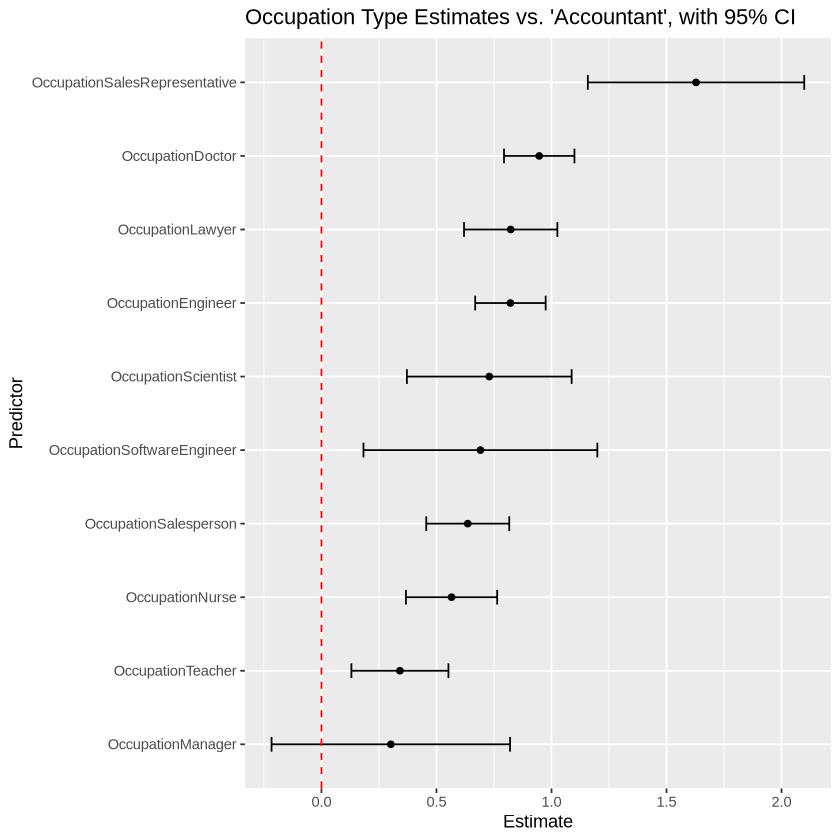

In [12]:
model_results <- tidy(aic_model, conf.int = TRUE) %>%
  filter(term != "(Intercept)") %>%
  mutate(
    direction = ifelse(
      p.value < 0.05,
      ifelse(estimate > 0, "Positive", "Negative"),
      "Neither"
    )
  )

occupation_vars <- model_results %>% filter(grepl("^Occupation", term))
sleep_disorder_vars <- model_results %>% filter(grepl("^SleepDisorder", term))
other_vars <- model_results %>%
  filter(!grepl("^Occupation", term) & !grepl("^SleepDisorder", term))

plot_ci <- function(data, title) {
  ggplot(data, aes(x = estimate, y = reorder(term, estimate))) +
    geom_point() +
    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), height = 0.2) +
    geom_vline(xintercept = 0, linetype = "dashed", color = "red") +
    labs(title = title, x = "Estimate", y = "Predictor")
}

plot_ci(occupation_vars, "Occupation Type Estimates vs. 'Accountant', with 95% CI")


For sleep disorder:

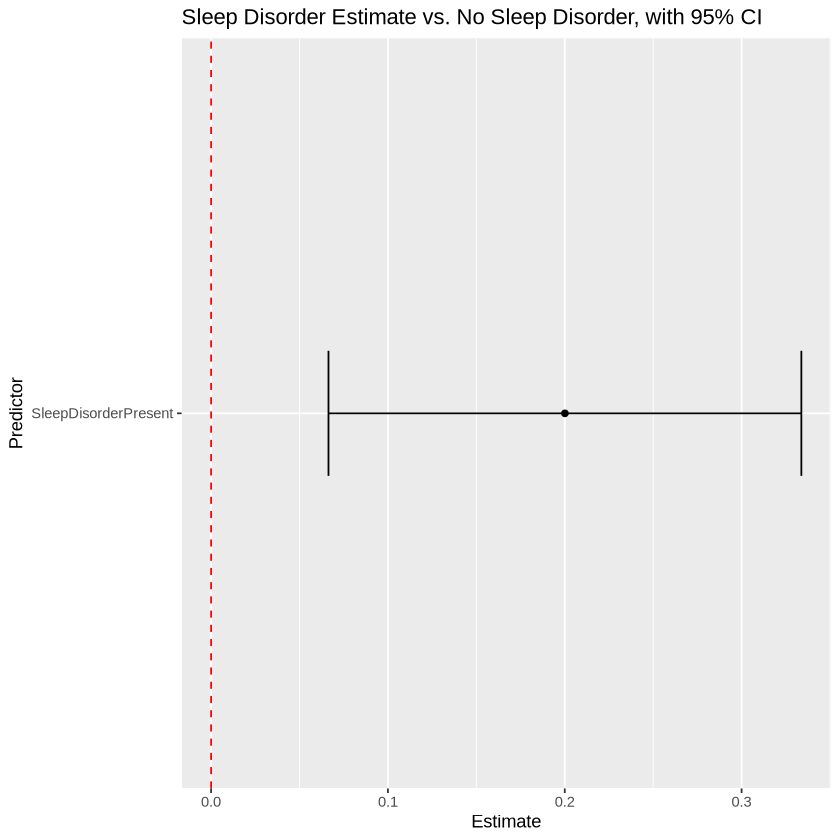

In [13]:
sleep_disorder_var <- model_results %>% filter(grepl("^SleepDisorder", term))
plot_ci(sleep_disorder_var, "Sleep Disorder Estimate vs. No Sleep Disorder, with 95% CI")


For all other estimates:

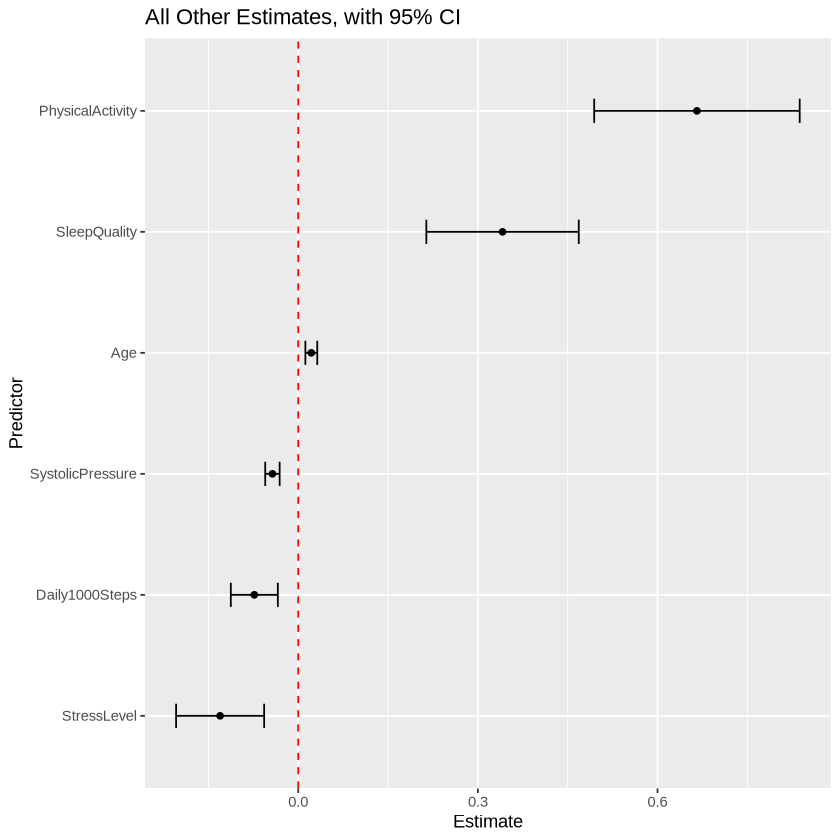

In [14]:
plot_ci(other_vars, "All Other Estimates, with 95% CI")

These graphs have a clean visualization of the significance of each predictor using mean and CI, as well as showing the direction of association.

# VALIDATION

Here we start using the test set to validate our stepAIC model.

In [15]:
prediction_test <- predict(aic_model, newdata = sleep_test)
actual <- sleep_test$SleepDuration
residual <- actual - prediction_test
RMSE <- sqrt(mean(residual^2))
MAE <- mean(abs(residual))
R2 <- 1 - sum(residual^2) / sum((actual - mean(actual))^2)

print(c(RMSE = RMSE, MAE = MAE, R2 = R2))

mean_sleep <- mean(sleep_test$SleepDuration)
relative_RMSE <- RMSE / mean_sleep
relative_MAE <- MAE / mean_sleep

print(paste("RMSE RELATIVE TO MEAN SLEEP DURATION: ", round(relative_RMSE,4)))
print(paste("MAE RELATIVE TO MEAN SLEEP DURATION: ", round(relative_MAE,4)))

     RMSE       MAE        R2 
0.2974714 0.2148082 0.8540618 
[1] "RMSE RELATIVE TO MEAN SLEEP DURATION:  0.0416"
[1] "MAE RELATIVE TO MEAN SLEEP DURATION:  0.0301"


Summary of test-set validation:

- RMS error: about 0.297 hrs sleep duration.
- Relative RMSE: about 0.0416, good.
- MA error: 0.215 hrs.
- Relative MAE: about 0.0301, good.
- R^2: 0.854, good.

# extra diagnostics

Warning message:
“not plotting observations with leverage one:
  140, 171”


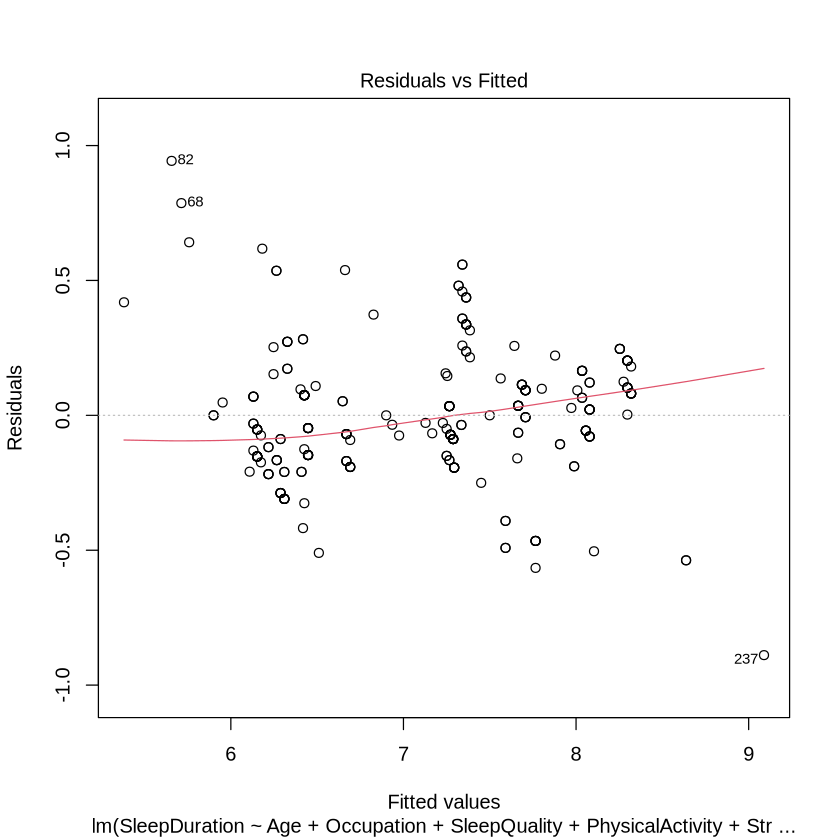

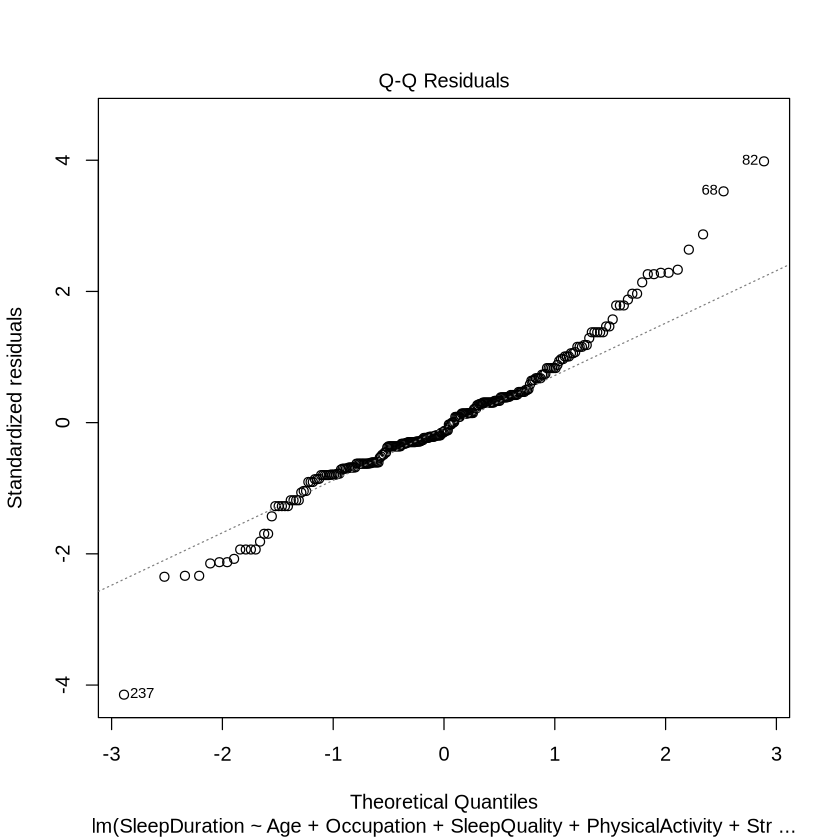

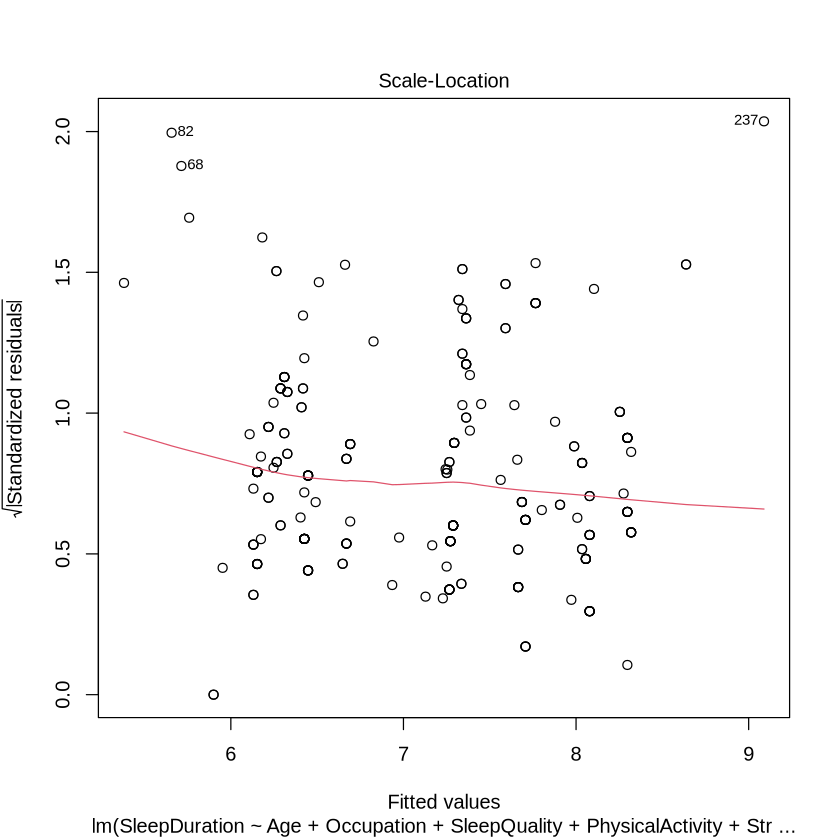

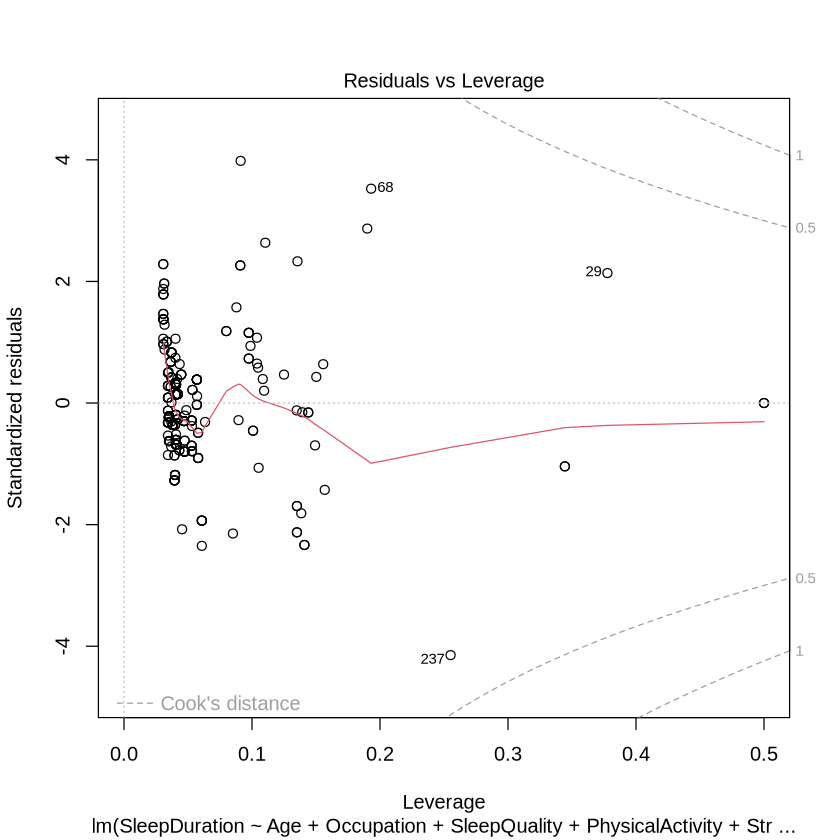

In [16]:
plot(aic_model)  # 4 base plots: residuals, Q-Q, scale-location, leverage